In [3]:
import os
import pinocchio as pin
import numpy as np
ASSETS_PATH = 'assets'
class D1Model:
    def __init__(self):
        urdf_path = os.path.join(ASSETS_PATH, 'urdf/d1_description.urdf')
        urdf_root_path = os.path.join(ASSETS_PATH, 'urdf')
        self.robot = pin.RobotWrapper.BuildFromURDF(urdf_path, urdf_root_path)
        self.data = self.robot.data

    def forwardKinematics(self, q):
        self.robot.framesForwardKinematics(q)
        ef_frames = ['Link6']
        return {frame: self.robot.data.oMf[self.robot.model.getFrameId(frame)].homogeneous
                for frame in ef_frames}

    

In [4]:
import time
import mujoco
import mujoco.viewer
import numpy as np
import os
from scipy.spatial.transform import Rotation
import cv2
from threading import Thread

class D1Sim:
    def __init__(self, 
                 mode='lowlevel', 
                 render=True, 
                 dt=0.002, 
                 height_map = None, 
                 xml_path=None,
                 camera_name = "front_camera", 
                 camera_resolution = (640, 480),
                 camera_depth_range = (0.35, 3.0), 
                 friction_model = None,
                 async_mode = False,
                 ):

        if xml_path is None:
            self.model = mujoco.MjModel.from_xml_path(
                os.path.join(ASSETS_PATH, 'mujoco/d1.xml')
            )
        else:
            self.model = mujoco.MjModel.from_xml_path(xml_path)

        if height_map is not None:
            try:
                self.updateHeightMap(height_map)
            except:
                raise Exception('Could not set height map. Are you sure the XML contains the required asset?')
        self.friction_model = friction_model
        self.simulated = True
        self.data = mujoco.MjData(self.model)
        self.dt = dt
        _render_dt = 1 / 60
        self.render_ds_ratio = max(1, _render_dt // dt)

        if render:
            self.viewer = mujoco.viewer.launch_passive(self.model, self.data)
            self.render = True
            self.viewer.cam.distance = 3.0
            self.viewer.cam.azimuth = 90
            self.viewer.cam.elevation = -45
            self.viewer.cam.lookat[:] = np.array([0.0, -0.25, 0.824])
        else:
            self.render = False

        self.model.opt.gravity[2] = -9.81
        self.model.opt.timestep = dt
        self.renderer = None
        self.render = render
        self.step_counter = 0

        self.q0 = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

        self.show(self.q0)
        mujoco.mj_step(self.model, self.data)
        if self.render:
            self.viewer.sync()
        self.nv = self.model.nv
        self.jacp = np.zeros((3, self.nv))
        self.jacr = np.zeros((3, self.nv))
        self.M = np.zeros((self.nv, self.nv))

    def show(self, q):
        self.data.qpos = q
        self.data.qvel = np.zeros_like(q)
        mujoco.mj_step(self.model, self.data)
        if self.render:
            self.viewer.sync()


In [5]:
sim = D1Sim()

In [2]:
model = D1Model()
model.forwardKinematics(np.zeros(8))['Link6']

array([[-3.67311066e-06,  7.34641021e-06,  1.00000000e+00,
         2.80380187e-01],
       [ 7.34646418e-06,  1.00000000e+00, -7.34638322e-06,
        -1.28243754e-03],
       [-1.00000000e+00,  7.34643719e-06, -3.67316463e-06,
         4.19921471e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

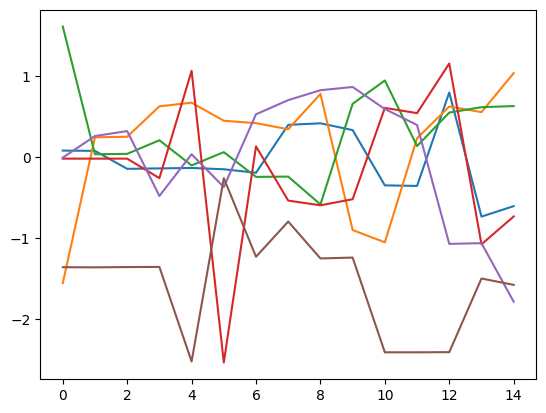

In [6]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
def loadPickle(path):
    with open(path, 'rb') as f:
        data = pickle.load(f)
    return data

A = np.array(loadPickle('handeye_data_A.pkl'))
B = np.array(loadPickle('handeye_data_B.pkl'))
qs = np.array(loadPickle('q_rad_list.pkl'))
plt.plot(qs[:,:6])

In [19]:
q = np.zeros(8)
# q[:6] = qs[5,:6]
q[5]=0
sim.show(q)

In [20]:
qs[:,5]

array([-1.35786616, -1.35961149, -1.35612083, -1.3543755 , -2.52200077,
       -0.25830873, -1.22871179, -0.79412481, -1.24965574, -1.23918377,
       -2.40855437, -2.40855437, -2.40680904, -1.4974925 , -1.57603231])

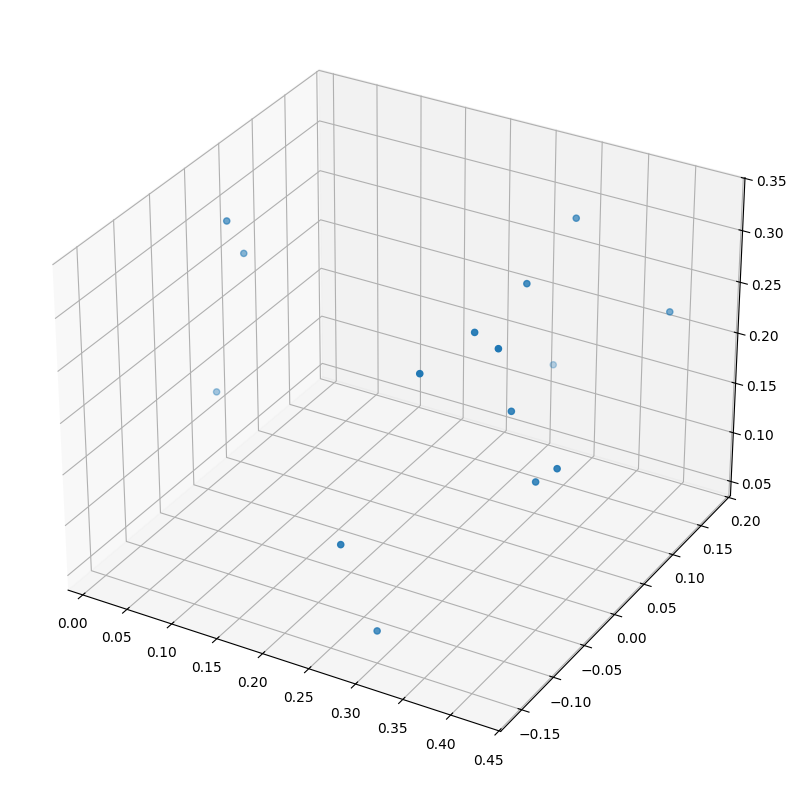

In [4]:
import matplotlib.pyplot as plt



fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d') 

ps = A[:,:3, -1]

ax.scatter(ps[:,0], ps[:,1], ps[:,2])

In [5]:
from SimpleHandEye.solvers import OpenCVSolver
solver = OpenCVSolver(type='AX=YB')
X, Y = solver.solve(A, B)

In [10]:
(A@X-Y@B)[:,:3,-1]

array([[-0.43426674,  0.09561868,  0.07199864],
       [ 0.0874121 ,  0.11671021,  0.08586425],
       [ 0.04372968, -0.1755348 ,  0.0070897 ],
       [ 0.28973406, -0.06045838, -0.06662042],
       [ 0.32319716, -0.12445266, -0.06610313],
       [ 0.11987797,  0.07493711, -0.12411291],
       [ 0.06923969, -0.18201095, -0.05421921],
       [ 0.01969969,  0.14099401,  0.06232689],
       [ 0.10630238,  0.18011006, -0.17727654],
       [-0.49489542, -0.11485016,  0.08887824],
       [-0.41433742,  0.10429213,  0.20022733],
       [ 0.03566635, -0.17102235, -0.00355133],
       [ 0.08109588,  0.32322752, -0.00531259],
       [ 0.03707309, -0.10247018, -0.09318275],
       [ 0.13047153, -0.10509026,  0.07399383]])